In [1]:
import pygplates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import matplotlib.gridspec as gridspec
from pandas import Series,DataFrame
import seaborn as sns
from gprm import ReconstructionModel

import get_distances_for_dataframe as gdfd

%load_ext autoreload
%autoreload 2

#import matplotlib as mpl
#mpl.rcParams['figure.facecolor'] = 'w'

pygmt-session [WARNING]: Representation of font type not recognized. Using default.
pygmt-session [WARNING]: Representation of font type not recognized. Using default.
pygmt-session [WARNING]: Representation of font type not recognized. Using default.
begin [WARNING]: Representation of font type not recognized. Using default.
begin [WARNING]: Representation of font type not recognized. Using default.
begin [WARNING]: Representation of font type not recognized. Using default.


In [2]:
df_ABC_distance = pd.read_excel('data/DZDB4.xlsx',sheet_name="Samples")
df_ABC_distance = df_ABC_distance.rename(columns={'distance_subduction':'distance'})
df_ABC_distance = df_ABC_distance.rename(columns={'distance_Sengor_Natalin_rifts':'distance_rifts'})
df_ABC_distance = df_ABC_distance.rename(columns={'distance_passive_margin_rifts':'distance_passive_margin'})
df_ABC_distance = df_ABC_distance.rename(columns={'distance_SN_PM_rifts':'distance_SN_PM'})
#dataframe_age0 = df_ABC_distance[df_ABC_distance['Est. Depos. Age (Ma)'] == 0]
dataframe_age01 = df_ABC_distance[np.logical_and(df_ABC_distance['Est. Depos. Age (Ma)'] >= 0 , df_ABC_distance['Est. Depos. Age (Ma)'] <= 100)]
dataframe_age0 = df_ABC_distance[df_ABC_distance['Est. Depos. Age (Ma)'] == 0]
dataframe_age1 = df_ABC_distance[np.logical_and(df_ABC_distance['Est. Depos. Age (Ma)'] > 0 , df_ABC_distance['Est. Depos. Age (Ma)'] <= 100)]
dataframe_age2 = df_ABC_distance[np.logical_and(df_ABC_distance['Est. Depos. Age (Ma)'] > 100 , df_ABC_distance['Est. Depos. Age (Ma)'] <= 200)]
dataframe_age3 = df_ABC_distance[np.logical_and(df_ABC_distance['Est. Depos. Age (Ma)'] > 200 , df_ABC_distance['Est. Depos. Age (Ma)'] <= 300)]
dataframe_age4 = df_ABC_distance[np.logical_and(df_ABC_distance['Est. Depos. Age (Ma)'] > 300 , df_ABC_distance['Est. Depos. Age (Ma)'] <= 410)]

In [3]:
df_ABC_distance_m2016 = pd.read_excel('data/DZDB5.xlsx',sheet_name="Samples")
df_ABC_distance_m2016 = df_ABC_distance_m2016.rename(columns={'distance_Sengor_Natalin_rifts':'distance_rifts'})
df_ABC_distance_m2016 = df_ABC_distance_m2016.rename(columns={'distance_passive_margin_rifts':'distance_passive_margin'})
df_ABC_distance_m2016 = df_ABC_distance_m2016.rename(columns={'distance_SN_PM_rifts':'distance_SN_PM'})
#dataframe_age0 = df_ABC_distance[df_ABC_distance['Est. Depos. Age (Ma)'] == 0]
dataframe_age01_m2016 = df_ABC_distance_m2016[np.logical_and(df_ABC_distance_m2016['Est. Depos. Age (Ma)'] >= 0 , df_ABC_distance_m2016['Est. Depos. Age (Ma)'] <= 100)]
dataframe_age0_m2016 = df_ABC_distance_m2016[df_ABC_distance_m2016['Est. Depos. Age (Ma)'] == 0]
dataframe_age1_m2016 = df_ABC_distance_m2016[np.logical_and(df_ABC_distance_m2016['Est. Depos. Age (Ma)'] > 0 , df_ABC_distance_m2016['Est. Depos. Age (Ma)'] <= 100)]
dataframe_age2_m2016 = df_ABC_distance_m2016[np.logical_and(df_ABC_distance_m2016['Est. Depos. Age (Ma)'] > 100 , df_ABC_distance_m2016['Est. Depos. Age (Ma)'] <= 200)]
dataframe_age3_m2016 = df_ABC_distance_m2016[np.logical_and(df_ABC_distance_m2016['Est. Depos. Age (Ma)'] > 200 , df_ABC_distance_m2016['Est. Depos. Age (Ma)'] <= 300)]
dataframe_age4_m2016 = df_ABC_distance_m2016[np.logical_and(df_ABC_distance_m2016['Est. Depos. Age (Ma)'] > 300 , df_ABC_distance_m2016['Est. Depos. Age (Ma)'] <= 410)]

In [4]:
df_Sample_MDA = pd.read_csv('data/Comparison_Est_Max_410Ma.csv',sep=',')
df_Sample_MDA= df_Sample_MDA[df_Sample_MDA['difference_absolute_value_YSG_EDA'] > 0.]
print(len(df_Sample_MDA))

df_Sample_MDA = df_Sample_MDA.rename(columns={'distance_subduction':'distance'})
df_Sample_MDA = df_Sample_MDA.rename(columns={'distance_Sengor_Natalin_rifts':'distance_rifts'})
df_Sample_MDA = df_Sample_MDA.rename(columns={'distance_passive_margin_rifts':'distance_passive_margin'})
df_Sample_MDA = df_Sample_MDA.rename(columns={'distance_SN_PM_rifts':'distance_SN_PM'})
#dataframe_age0 = df_ABC_distance[df_ABC_distance['Est. Depos. Age (Ma)'] == 0]
'''df_Sample_MDA01 = df_Sample_MDA[np.logical_and(df_Sample_MDA['Est. Depos. Age (Ma)'] >= 0 , df_Sample_MDA['Est. Depos. Age (Ma)'] <= 100)]
df_Sample_MDA0 = df_Sample_MDA[df_Sample_MDA['Est. Depos. Age (Ma)'] == 0]
df_Sample_MDA1 = df_Sample_MDA[np.logical_and(df_Sample_MDA['Est. Depos. Age (Ma)'] > 0 , df_Sample_MDA['Est. Depos. Age (Ma)'] <= 100)]
df_Sample_MDA2 = df_Sample_MDA[np.logical_and(df_Sample_MDA['Est. Depos. Age (Ma)'] > 100 , df_Sample_MDA['Est. Depos. Age (Ma)'] <= 200)]
df_Sample_MDA3 = df_Sample_MDA[np.logical_and(df_Sample_MDA['Est. Depos. Age (Ma)'] > 200 , df_Sample_MDA['Est. Depos. Age (Ma)'] <= 300)]
df_Sample_MDA4 = df_Sample_MDA[np.logical_and(df_Sample_MDA['Est. Depos. Age (Ma)'] > 300 , df_Sample_MDA['Est. Depos. Age (Ma)'] <= 410)]'''

df_Sample_MDA01 = df_Sample_MDA[np.logical_and(df_Sample_MDA['YSG_value'] >= 0 , df_Sample_MDA['YSG_value'] <= 100)]
df_Sample_MDA0 = df_Sample_MDA[df_Sample_MDA['YSG_value'] == 0]
df_Sample_MDA1 = df_Sample_MDA[np.logical_and(df_Sample_MDA['YSG_value'] > 0 , df_Sample_MDA['YSG_value'] <= 100)]
df_Sample_MDA2 = df_Sample_MDA[np.logical_and(df_Sample_MDA['YSG_value'] > 100 , df_Sample_MDA['YSG_value'] <= 200)]
df_Sample_MDA3 = df_Sample_MDA[np.logical_and(df_Sample_MDA['YSG_value'] > 200 , df_Sample_MDA['YSG_value'] <= 300)]
df_Sample_MDA4 = df_Sample_MDA[np.logical_and(df_Sample_MDA['YSG_value'] > 300 , df_Sample_MDA['YSG_value'] <= 410)]


5997


In [5]:
print(len(df_Sample_MDA))
print(len(df_Sample_MDA01))
print(len(df_Sample_MDA0))
print(len(df_Sample_MDA1))
print(len(df_Sample_MDA2))
print(len(df_Sample_MDA3))
print(len(df_Sample_MDA4))
df_Sample_MDA410 = df_Sample_MDA[df_Sample_MDA['YSG_value'] > 410]
print(len(df_Sample_MDA410))


5997
2298
1
2297
1041
1250
755
651


In [6]:
a = df_Sample_MDA[df_Sample_MDA['YSG_value'] <= 410]
a['type_MDA_YSG'].value_counts()


B    2565
A    1916
C     865
Name: type_MDA_YSG, dtype: int64

In [7]:
df_ABC_distance['type'].value_counts()

B    2255
C    2044
A    1767
Name: type, dtype: int64

In [8]:
print(len(df_ABC_distance))
print(len(dataframe_age01))
print(len(dataframe_age0))
print(len(dataframe_age1))
print(len(dataframe_age2))
print(len(dataframe_age3))
print(len(dataframe_age4))
dataframe_age410 = df_ABC_distance[df_ABC_distance['Est. Depos. Age (Ma)'] > 410]
print(len(dataframe_age410))

6066
3266
1201
2065
974
1100
726
0


In [10]:
from gprm.datasets import Reconstructions
Y2019 = Reconstructions.fetch_Young2019()

import public
active_rifts = public.fetch_active_rifts()
inactive_rifts = public.fetch_inactive_rifts()
active_passive_margin = public.fetch_active_passive_margin()
inactive_passive_margin = public.fetch_inactive_passive_margin()

Rift2019 = Reconstructions.fetch_Young2019()

rifts_active = pygplates.FeatureCollection()
list_of_riftfiles_active = ['{:s}'.format(active_rifts),
                            '{:s}'.format(active_passive_margin)]
for riftfile in list_of_riftfiles_active:
    for feature in pygplates.FeatureCollection(riftfile):
        rifts_active.add(feature)
        
rifts_active_pm = pygplates.FeatureCollection()
list_of_riftfiles_active_pm = ['{:s}'.format(inactive_rifts),
                              '{:s}'.format(active_passive_margin),
                              '{:s}'.format(inactive_passive_margin)]
for riftfile in list_of_riftfiles_active_pm:
    for feature in pygplates.FeatureCollection(riftfile):
        rifts_active_pm.add(feature)
        
rifts3 = pygplates.FeatureCollection()
list_of_riftfiles3 = [active_rifts,inactive_rifts,active_passive_margin,inactive_passive_margin]

for riftfile in list_of_riftfiles3:
    for feature in pygplates.FeatureCollection(riftfile):
        rifts3.add(feature)

In [11]:
df_Sample_MDA01.columns

Index(['Sample_No.', 'Ref_Number', 'Ref_Sample_Key',
       'Ref No. In_Source_Database', 'Sample No. In_Source_Database',
       'Source_Database', 'Published Sample_ID', 'Country/State', 'Region',
       'Continent', 'Major Geographic-Geologic Description',
       'Minor Geologic-Geographic Unit', 'Locality', 'Latitude', 'Longitude',
       'Max. Depos. Age (Ma)', 'Est. Depos. Age (Ma)', 'Min. Depos. Age (Ma)',
       'Mineral', 'Mass Spectrometer', 'Spectrometer Location', 'Institution',
       'Spectrometer Model', 'Class-1 Rock Type', 'Class-2 Rock Type',
       'Class-3 Rock Type', 'Felsic/Mafic', 'Max Latitude', 'Min Latitude',
       'Max Longitude', 'Min Longitude', 'U-Pb Record Count',
       'U-Pb Record Count Standard_Model_Age', 'type', 'colour', 'FROMAGE',
       'TOAGE', 'distance', 'distance_subduction_m2016', 'distance_rifts',
       'distance_passive_margin', 'distance_SN_PM', 'distance_active',
       'distance_inactive', 'distance_active_passive_margin', 'YSG_value'

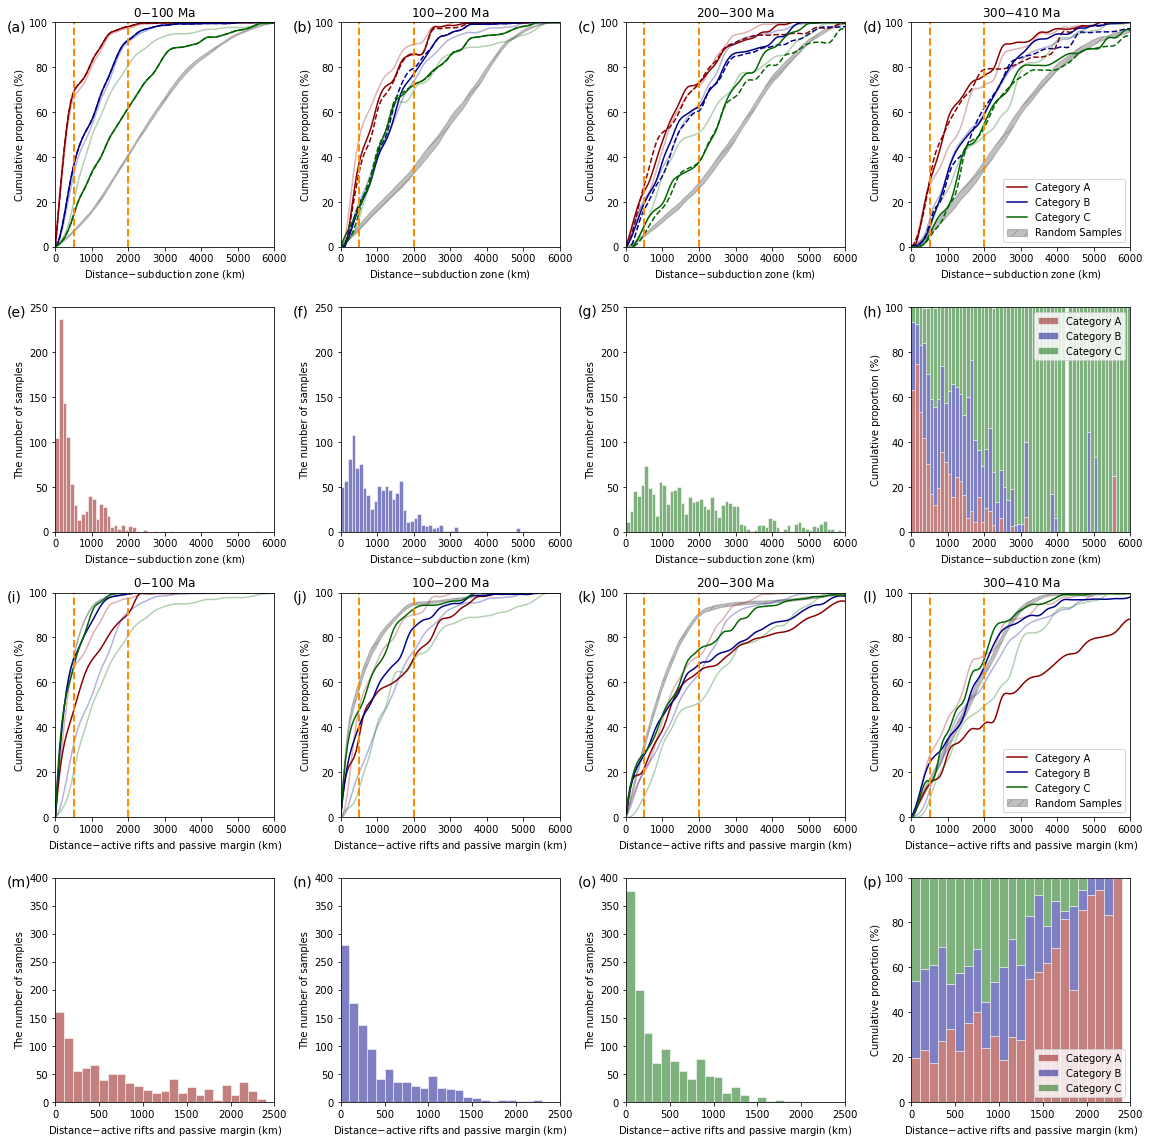

In [12]:
import statsmodels.api as sm # recommended import according to the docs
from scipy.interpolate import make_interp_spline

#dataframe_age01 = dataframe_age1
#dataframe_age01_m2016 = dataframe_age1_m2016
#df_Sample_MDA01 = df_Sample_MDA1

labels = ['0$-$100 Ma', '100$-$200 Ma', '200$-$300 Ma', '300$-$410 Ma']
df_ABC_distance = [dataframe_age01, dataframe_age2, dataframe_age3, dataframe_age4]
df_ABC_distance_m2016 = [dataframe_age01_m2016, dataframe_age2_m2016, dataframe_age3_m2016, dataframe_age4_m2016]
df_Sample_MDAs = [df_Sample_MDA01, df_Sample_MDA2, df_Sample_MDA3, df_Sample_MDA4]
data_type = ['A', 'B', 'C']
colors = ['darkred','darkblue','darkgreen']

legends = ['Category A', 'Category B', 'Category C']
no_texts1 = ['(a)','(b)','(c)','(d)']
no_texts2 = ['(e)','(f)','(g)','(h)']

fig, ax = plt.subplots(4, 4, figsize = (16,16))
#fig, ax = plt.subplots(2, 4, sharex=True, figsize = (16,8))

#panels1 = [[0,0],[0,1],[0,2],[0,3]]
panelsx1 = [0,0,0,0]
panelsy1 = [0,1,2,3]
reconstruction_times = [50.,150.,250.,350.]
      
for df in range(4):
    for i in range(3):
        Sample_type = df_ABC_distance[df][df_ABC_distance[df]['type'] == data_type[i]]
        #print(len(Sample_type['distance']))
        ecdf = sm.distributions.ECDF(Sample_type['distance'])
        x = np.linspace(0, 6000, 30)
        y = ecdf(x)
        x_smooth = np.linspace(x.min(), x.max(), 100)
        y_smooth = make_interp_spline(x, y)(x_smooth)
        ax[panelsx1[df],panelsy1[df]].plot(x_smooth, y_smooth*100, color = colors[i], alpha=1, label = legends[i])
        
        Sample_type_m2016 = df_ABC_distance_m2016[df][df_ABC_distance_m2016[df]['type'] == data_type[i]]        
        ecdf = sm.distributions.ECDF(Sample_type_m2016['distance_subduction_m2016'])
        x = np.linspace(0, 6000, 30)
        y = ecdf(x)
        x_smooth = np.linspace(x.min(), x.max(), 100)
        y_smooth = make_interp_spline(x, y)(x_smooth)
        ax[panelsx1[df],panelsy1[df]].plot(x_smooth, y_smooth*100, ls="--", color = colors[i], alpha=1)
        #if data_type[i] == 'A':
        Sample_type_MDA_YSG = df_Sample_MDAs[df][df_Sample_MDAs[df]['type_MDA_YSG'] == data_type[i]]        
        ecdf = sm.distributions.ECDF(Sample_type_MDA_YSG['distance'])
        x = np.linspace(0, 6000, 30)
        y = ecdf(x)
        x_smooth = np.linspace(x.min(), x.max(), 100)
        y_smooth = make_interp_spline(x, y)(x_smooth)
        ax[panelsx1[df],panelsy1[df]].plot(x_smooth, y_smooth*100, color = colors[i], alpha=0.3)

        '''Sample_type_MDA_YC2s = df_Sample_MDAs[df][df_Sample_MDAs[df]['type_MDA_YC2s'] == data_type[i]]        
        ecdf = sm.distributions.ECDF(Sample_type_MDA_YC2s['distance'])
        x = np.linspace(0, 6000, 30)
        y = ecdf(x)
        x_smooth = np.linspace(x.min(), x.max(), 100)
        y_smooth = make_interp_spline(x, y)(x_smooth)
        ax[panelsx1[df],panelsy1[df]].plot(x_smooth, y_smooth*100, ls='dashdot', color = colors[i], alpha=1)'''
        
    data_distance = []
    random_number=len(df_ABC_distance[df])
    for ii in range(20): 
        data_distance_time = []
        mlo, mla = gdfd.get_random_points_within_continents(Y2019, reconstruction_times[df], number_of_points=int(random_number*2.6))
        #print(random_number)
        #print(len(mlo))
        df_random = pd.DataFrame({'Longitude':mlo,'Latitude':mla})
        df_random['FROMAGE'] = reconstruction_times[df] + 5
        df_random['TOAGE'] = reconstruction_times[df] - 5
        rlo,rla,rd = gdfd.get_distances_for_dataframe(df_random, Y2019, reconstruction_times[df])
        data_distance_time.extend(rd)
        
        ecdf = sm.distributions.ECDF(data_distance_time)
        x = np.linspace(0, 6000, 30)
        y = ecdf(x)
        x_smooth = np.linspace(x.min(), x.max(), 100)
        y_smooth = make_interp_spline(x, y)(x_smooth)
        data_distance.append(y_smooth*100)
    rd_mean=np.quantile(data_distance, 0.5, axis=0)
    std = np.std(data_distance, axis=0)
    ax[panelsx1[df],panelsy1[df]].fill_between(x_smooth, rd_mean - std, rd_mean + std, color = 'grey', label = 'Random Samples', edgecolor='grey', hatch='//', alpha=0.5)
    ax[panelsx1[df],panelsy1[df]].axvline(500,c="DarkOrange", ls="--", lw=2)
    ax[panelsx1[df],panelsy1[df]].axvline(2000,c="DarkOrange", ls="--", lw=2)
    #ax[panelsx1[df],panelsy1[df]].axvline(3000,c="DarkOrange", ls="--", lw=2)
    ax[panelsx1[df],panelsy1[df]].set_title(labels[df])
    ax[panelsx1[df],panelsy1[df]].set_ylim(0,100)
    ax[panelsx1[df],panelsy1[df]].set_xlim(0,6000,500)
    ax[panelsx1[df],panelsy1[df]].set_xlabel('Distance$-$subduction zone (km)')
    ax[panelsx1[df],panelsy1[df]].set_ylabel('Cumulative proportion (%)')
    ax[panelsx1[df],panelsy1[df]].text(-0.22, 0.95, no_texts1[df],
    verticalalignment='bottom', horizontalalignment='left', transform=ax[panelsx1[df],panelsy1[df]].transAxes, color='black', fontsize=14)
ax[panelsx1[0],panelsy1[3]].legend(loc = 'lower right')

#The first three panels
#panels2 = [4,5,6]
panelsx2 = [1,1,1]
panelsy2 = [0,1,2]
bins=range(0,6000,100)
for i in range(3):
    Sample_type = dataframe_age01[dataframe_age01['type'] == data_type[i]]
    #print(len(Sample_type['distance']))
    ax[panelsx2[i],panelsy2[i]].hist(Sample_type['distance'], bins, histtype='bar', color = colors[i], label = legends[i], edgecolor='w', alpha=0.5) 
    #ax[panelsx2[i],panelsy2[i]].legend(loc = 'best')
    ax[panelsx2[i],panelsy2[i]].set_xlabel('Distance$-$subduction zone (km)')
    ax[panelsx2[i],panelsy2[i]].set_ylabel('The number of samples')
    ax[panelsx2[i],panelsy2[i]].set_ylim(0,250)
    ax[panelsx2[i],panelsy2[i]].set_xlim(0,6000,100)
    ax[panelsx2[i],panelsy2[i]].text(-0.22, 0.95, no_texts2[i],
    verticalalignment='bottom', horizontalalignment='left',
    transform=ax[panelsx2[i],panelsy2[i]].transAxes,
    color='black', fontsize=14)

#The fourth panel
min_diss=np.arange(0.,6000.,100)
interval_dis=100.
xlables=np.arange(50.,6050.,100)
width = 100.
ratios_A = []
ratios_B = []
ratios_C = []

for i, min_dis in enumerate(min_diss):
    max_dis = min_dis + interval_dis
    Sample_distance = dataframe_age01[np.logical_and(dataframe_age01['distance'] >= min_dis , dataframe_age01['distance'] <= max_dis )]
    Sample_type = Sample_distance['type'].to_list()
    if len(Sample_type) > 0:
        count_A = np.round(Sample_type.count('A')/len(Sample_type), 3)
    else:
        count_A = 0
    ratios_A.append(count_A)
    if len(Sample_type) > 0:
        count_B = np.round(Sample_type.count('B')/len(Sample_type), 3)
    else:
        count_B = 0
    ratios_B.append(count_B)
    if len(Sample_type) > 0:
        count_C = np.round(Sample_type.count('C')/len(Sample_type), 3)
    else:
        count_C = 0
    ratios_C.append(count_C)
ratios_A = (np.array(ratios_A)*100).tolist()    
ratios_B = (np.array(ratios_B)*100).tolist()    
ratios_C = (np.array(ratios_C)*100).tolist()    

ax[1,3].bar(xlables, ratios_A, width, color='darkred', label='Category A', edgecolor='w', alpha=0.5)
ax[1,3].bar(xlables, ratios_B, width, color='darkblue', bottom=ratios_A, label='Category B', edgecolor='w', alpha=0.5)
cum =list(map(sum, zip(list(ratios_A),list(ratios_B))))
ax[1,3].bar(xlables, ratios_C, width, color='darkgreen', bottom=cum, label='Category C', edgecolor='w', alpha=0.5)
ax[1,3].set_ylim(0,100)
ax[1,3].set_xlim(0,6000,500)
ax[1,3].set_xlabel('Distance$-$subduction zone (km)')
ax[1,3].set_ylabel('Cumulative proportion (%)')
#ax.set_title('')
ax[1,3].legend(loc = 'upper right') 
ax[1,3].text(-0.22, 0.95, no_texts2[3],
    verticalalignment='bottom', horizontalalignment='left',
    transform=ax[1,3].transAxes,
    color='black', fontsize=14)
#ax[1,3].set_yticks(range(0,100,20))



# 分界线， i-p是rifts的图
no_texts1 = ['(i)','(j)','(k)','(l)']
no_texts2 = ['(m)','(n)','(o)','(p)']

panelsx1 = [2,2,2,2]
panelsy1 = [0,1,2,3]
reconstruction_times = [50.,150.,250.,350.]
for df in range(4):
    for i in range(3):
        Sample_type = df_ABC_distance[df][df_ABC_distance[df]['type'] == data_type[i]]
        #print(len(Sample_type['distance']))
        ecdf = sm.distributions.ECDF(Sample_type['distance_active_passive_margin'])
        x = np.linspace(0, 6000, 30)
        y = ecdf(x)

        x_smooth = np.linspace(x.min(), x.max(), 100)
        y_smooth = make_interp_spline(x, y)(x_smooth)
        ax[panelsx1[df],panelsy1[df]].plot(x_smooth, y_smooth*100, color = colors[i], alpha=1, label = legends[i])
        
        Sample_type_MDA_YSG = df_Sample_MDAs[df][df_Sample_MDAs[df]['type_MDA_YSG'] == data_type[i]]        
        ecdf = sm.distributions.ECDF(Sample_type_MDA_YSG['distance'])
        x = np.linspace(0, 6000, 30)
        y = ecdf(x)
        x_smooth = np.linspace(x.min(), x.max(), 100)
        y_smooth = make_interp_spline(x, y)(x_smooth)
        ax[panelsx1[df],panelsy1[df]].plot(x_smooth, y_smooth*100, color = colors[i], alpha=0.3)
        
    data_distance = []
    random_number=len(df_ABC_distance[df])
    for ii in range(20): 
        data_distance_time = []
        mlo, mla = gdfd.get_random_points_within_continents(Y2019, reconstruction_times[df], number_of_points=int(random_number*2.6))
        #print(random_number)
        #print(len(mlo))
        df_random = pd.DataFrame({'Longitude':mlo,'Latitude':mla})
        df_random['FROMAGE'] = reconstruction_times[df] + 5
        df_random['TOAGE'] = reconstruction_times[df] - 5
        rlo,rla,rd = gdfd.get_distances_for_dataframe_rifts(df_random, Rift2019, rifts_active_pm, reconstruction_times[df])
        data_distance_time.extend(rd)
        
        ecdf = sm.distributions.ECDF(data_distance_time)
        x = np.linspace(0, 6000, 30)
        y = ecdf(x)
        x_smooth = np.linspace(x.min(), x.max(), 100)
        y_smooth = make_interp_spline(x, y)(x_smooth)
        data_distance.append(y_smooth*100)
    rd_mean=np.quantile(data_distance, 0.5, axis=0)
    std = np.std(data_distance, axis=0)
    ax[panelsx1[df],panelsy1[df]].fill_between(x_smooth, rd_mean - std, rd_mean + std, color = 'grey', label = 'Random Samples', edgecolor='grey', hatch='//', alpha=0.5)
    ax[panelsx1[df],panelsy1[df]].axvline(500,c="DarkOrange", ls="--", lw=2)
    ax[panelsx1[df],panelsy1[df]].axvline(2000,c="DarkOrange", ls="--", lw=2)
    #ax[panelsx1[df],panelsy1[df]].axvline(3000,c="DarkOrange", ls="--", lw=2)
    ax[panelsx1[df],panelsy1[df]].set_title(labels[df])
    ax[panelsx1[df],panelsy1[df]].set_ylim(0,100)
    ax[panelsx1[df],panelsy1[df]].set_xlim(0,6000,500)
    ax[panelsx1[df],panelsy1[df]].set_xlabel('Distance$-$active rifts and passive margin (km)')
    ax[panelsx1[df],panelsy1[df]].set_ylabel('Cumulative proportion (%)')
    ax[panelsx1[df],panelsy1[df]].text(-0.22, 0.95, no_texts1[df],
    verticalalignment='bottom', horizontalalignment='left', transform=ax[panelsx1[df],panelsy1[df]].transAxes, color='black', fontsize=14)
ax[panelsx1[2],panelsy1[3]].legend(loc = 'lower right')

#The first three panels
#panels2 = [4,5,6]
panelsx2 = [3,3,3]
panelsy2 = [0,1,2]
bins=range(0,8000,100)

for i in range(3):
    Sample_type = dataframe_age01[dataframe_age01['type'] == data_type[i]]
    #print(len(Sample_type['distance']))
    ax[panelsx2[i],panelsy2[i]].hist(Sample_type['distance_active_passive_margin'], bins, histtype='bar', color = colors[i], label = legends[i], edgecolor='w', alpha=0.5) 
    #ax[panelsx2[i],panelsy2[i]].legend(loc = 'best')
    ax[panelsx2[i],panelsy2[i]].set_xlabel('Distance$-$active rifts and passive margin (km)')
    ax[panelsx2[i],panelsy2[i]].set_ylabel('The number of samples')
    ax[panelsx2[i],panelsy2[i]].set_ylim(0,400)
    ax[panelsx2[i],panelsy2[i]].set_xlim(0,2500,100)
    ax[panelsx2[i],panelsy2[i]].text(-0.22, 0.95, no_texts2[i],
    verticalalignment='bottom', horizontalalignment='left',
    transform=ax[panelsx2[i],panelsy2[i]].transAxes,
    color='black', fontsize=14)
#The fourth panel
min_diss=np.arange(0.,6000.,100)
interval_dis=100.
xlables=np.arange(50.,6050.,100)
width = 100.
ratios_A = []
ratios_B = []
ratios_C = []

for i, min_dis in enumerate(min_diss):
    max_dis = min_dis + interval_dis
    Sample_distance = dataframe_age01[np.logical_and(dataframe_age01['distance_active_passive_margin'] >= min_dis , dataframe_age01['distance_active_passive_margin'] <= max_dis )]
    Sample_type = Sample_distance['type'].to_list()
    if len(Sample_type) > 0:
        count_A = np.round(Sample_type.count('A')/len(Sample_type), 3)
    else:
        count_A = 0
    ratios_A.append(count_A)
    if len(Sample_type) > 0:
        count_B = np.round(Sample_type.count('B')/len(Sample_type), 3)
    else:
        count_B = 0
    ratios_B.append(count_B)
    if len(Sample_type) > 0:
        count_C = np.round(Sample_type.count('C')/len(Sample_type), 3)
    else:
        count_C = 0
    ratios_C.append(count_C)
    
ratios_A = (np.array(ratios_A)*100).tolist()    
ratios_B = (np.array(ratios_B)*100).tolist()    
ratios_C = (np.array(ratios_C)*100).tolist()   

ax[3,3].bar(xlables, ratios_A, width, color='darkred', label='Category A', edgecolor='w', alpha=0.5)
ax[3,3].bar(xlables, ratios_B, width, color='darkblue', bottom=ratios_A, label='Category B', edgecolor='w', alpha=0.5)
cum =list(map(sum, zip(list(ratios_A),list(ratios_B))))
ax[3,3].bar(xlables, ratios_C, width, color='darkgreen', bottom=cum, label='Category C', edgecolor='w', alpha=0.5)
ax[3,3].set_ylim(0,100)
ax[3,3].set_xlim(0,2500,250)
ax[3,3].set_xlabel('Distance$-$active rifts and passive margin (km)')
ax[3,3].set_ylabel('Cumulative proportion (%)')
#ax.set_title('')
ax[3,3].legend(loc = 'lower right') 
ax[3,3].text(-0.22, 0.95, no_texts2[3],
    verticalalignment='bottom', horizontalalignment='left',
    transform=ax[3,3].transAxes,
    color='black', fontsize=14)
plt.tight_layout()

#fig.savefig('plots/figures/Figure7_withmordern.png', dpi=600)
#fig.savefig('plots/figures/Figure7_withoutmordern.png', dpi=600)

fig.savefig('plots/figures/Figure6.png', dpi=600)
fig.savefig('plots/figures/Figure6.png', dpi=600)

#fig.savefig('plots/figures/Figure7.pdf')

plt.show()